In [1]:
import csv
from heapq import heappush, heappop
from itertools import count
from lxml import etree as et
from math import sin, cos, sqrt, atan2, radians
import matplotlib.pyplot as plt
import networkx as nx
from random import random, sample
import numpy as np

In [2]:
# osm_file='data/graph.osm'
# f = open('data/orig_houses.txt', 'r')
# houses_id = [elem[:-1] for elem in f.readlines()]
# f.close()
# f = open('data/orig_med.txt', 'r')
# med_id = [elem[:-1] for elem in f.readlines()]   
# f.close()
# f = open('data/orig_fire_station.txt', 'r')
# fire_station_id = [elem[:-1] for elem in f.readlines()]
# f.close()
# f = open('data/orig_retail.txt', 'r')
# retail_id = [elem[:-1] for elem in f.readlines()]   
# f.close()

# G = nx.DiGraph()
# context = et.iterparse(osm_file, events=('end',), tag='node')
# nodes = {}
# for event, elem in context:
#     #Поменял lon и lat местами для разворота
#     nodes[elem.get('id')] = [float(elem.get('lon')),float(elem.get('lat'))]
#     elem.clear()
#     while elem.getprevious() is not None:
#         del elem.getparent()[0]
# del context
# G.add_nodes_from(nodes)

# def distance(node1,node2):
#     R = 6373.0
#     lat1 = radians(nodes[node1][1])#lat
#     lon1 = radians(nodes[node1][0])#lon
#     lat2 = radians(nodes[node2][1])
#     lon2 = radians(nodes[node2][0])

#     dlon = lon2 - lon1
#     dlat = lat2 - lat1

#     a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
#     c = 2 * atan2(sqrt(a), sqrt(1 - a))

#     distance = R * c
#     return distance

# def nearest_node_id(node_a_id, pass_list = []):    
#     min_dist = float('inf')
#     if pass_list.count(node_a_id) == 0:
#         pass_list.append(node_a_id)
#     for node_b_id in list(G.nodes()):
#         d = distance(node_a_id,node_b_id)
#         if d < min_dist and node_b_id not in pass_list:
#             min_dist = d
#             nni = node_b_id
#     return nni

# context = et.iterparse(osm_file,events=('end',),tag='way')
# edges = []
# for event, elem in context:
#     oneway = 0
#     #Определим свойства
#     for child in elem.iterchildren('tag'):
#         key = child.get('k')      
#         #Возможно, дорога односторонняя
#         if key == 'oneway' and child.get('v') == 'yes':
#             oneway = 1
#     #Узнаем, какие вершины состоят в пути
#     nodes_list = []
#     for child in elem.iterchildren('nd'):
#         _id = child.get('ref')
#         nodes_list.append(_id)
#     #Добавляем ребра с весами в список смежности
#     if False:#oneway == 1:
#         for i in range(len(nodes_list)-1):
#             #Добавляем вершины
#             from_node, to_node = nodes_list[i:i+2]
#             d = distance(from_node, to_node)
#             edges.append((from_node, to_node, {'weight': d}))
#     else:
#         for i in range(len(nodes_list)-1):
#             from_node, to_node = nodes_list[i:i+2]
#             d = distance(from_node, to_node)
#             edges.append((from_node, to_node, {'weight': d}))
#             edges.append((to_node, from_node, {'weight': d}))
#     elem.clear()
#     while elem.getprevious() is not None:
#         del elem.getparent()[0]
# del context
# G.add_edges_from(edges)    

# #Удалим лишнее
# for node in nodes:
#     if (len(list(G.successors(node))) == 1 or len(list(G.predecessors(node)))) == 1 and G.degree(node) != 1:
#         remove_list,add_list = [],[]
#         for from_node in G.predecessors(node):
#             for to_node in G.successors(node):
#                 remove_list.append((from_node,node))
#                 remove_list.append((node,to_node))
#                 add_list.append((from_node, to_node, {'weight':G[from_node][node]['weight']+G[node][to_node]['weight']}))
#         G.add_edges_from(add_list)
#         G.remove_edges_from(remove_list)
#         G.remove_node(node)

# remove_nodes = [node for node in G.nodes() if int(G.degree(node)) == 0]
   
# nearest_node_of_way(houses_id,'data/houses.txt',remove_nodes)
# nearest_node_of_way(med_id,'data/med.txt',remove_nodes)
# nearest_node_of_way(fire_station_id,'data/fire_station.txt',remove_nodes)
# nearest_node_of_way(retail_id,'data/retail.txt',remove_nodes)

In [3]:
def nearest_node_of_way(list_id,filename,remove_nodes):
    nearest_nodes_id = set()
    for _id in list_id:
        nni = nearest_node_id(_id,remove_nodes)
        nearest_nodes_id.add(nni)
    with open(filename,'w',newline='') as f:      
        s = '\n'.join(list(nearest_nodes_id))
        f.write(s+' ')

In [4]:
def create_graph_from_osm(osm_file='data/orig_graph.osm'): 
    G = nx.DiGraph()
    context = et.iterparse(osm_file, events=('end',), tag='node')
    nodes = {}
    for event, elem in context:
        #Поменял lon и lat местами для разворота
        nodes[elem.get('id')] = [float(elem.get('lon')),float(elem.get('lat'))]
        elem.clear()
        while elem.getprevious() is not None:
            del elem.getparent()[0]
    del context
    G.add_nodes_from(nodes)
    
    def distance(node1,node2):
        R = 6373.0
        lat1 = radians(nodes[node1][1])#lat
        lon1 = radians(nodes[node1][0])#lon
        lat2 = radians(nodes[node2][1])
        lon2 = radians(nodes[node2][0])

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))

        distance = R * c
        return distance

    def nearest_node_id(node_a_id, pass_list = []):    
        min_dist = float('inf')
        if pass_list.count(node_a_id) == 0:
            pass_list.append(node_a_id)
        for node_b_id in list(G.nodes()):
            d = distance(node_a_id,node_b_id)
            if d < min_dist and node_b_id not in pass_list:
                min_dist = d
                nni = node_b_id
        return nni
   
    context = et.iterparse(osm_file,events=('end',),tag='way')
    edges = []
    for event, elem in context:
        oneway = 0
        #Определим свойства
        for child in elem.iterchildren('tag'):
            key = child.get('k')      
            #Возможно, дорога односторонняя
            if key == 'oneway' and child.get('v') == 'yes':
                oneway = 1
        #Узнаем, какие вершины состоят в пути
        nodes_list = []
        for child in elem.iterchildren('nd'):
            _id = child.get('ref')
            nodes_list.append(_id)
        #Добавляем ребра с весами в список смежности
        if False:#oneway == 1:
            for i in range(len(nodes_list)-1):
                #Добавляем вершины
                from_node, to_node = nodes_list[i:i+2]
                d = distance(from_node, to_node)
                edges.append((from_node, to_node, {'weight': d}))
        else:
            for i in range(len(nodes_list)-1):
                from_node, to_node = nodes_list[i:i+2]
                d = distance(from_node, to_node)
                edges.append((from_node, to_node, {'weight': d}))
                edges.append((to_node, from_node, {'weight': d}))
        elem.clear()
        while elem.getprevious() is not None:
            del elem.getparent()[0]
    del context
    G.add_edges_from(edges)    
    
    #Удалим лишнее
    for node in nodes:
        if (len(list(G.successors(node))) == 1 or len(list(G.predecessors(node)))) == 1 and G.degree(node) != 1:
            remove_list,add_list = [],[]
            for from_node in G.predecessors(node):
                for to_node in G.successors(node):
                    remove_list.append((from_node,node))
                    remove_list.append((node,to_node))
                    add_list.append((from_node, to_node, {'weight':G[from_node][node]['weight']+G[node][to_node]['weight']}))
            G.add_edges_from(add_list)
            G.remove_edges_from(remove_list)
            G.remove_node(node)
    
    remove_nodes = [node for node in G.nodes() if int(G.degree(node)) == 0]
    
    houses_id = increase_dist(G,'data/houses.txt')
    med_id = increase_dist(G,'data/med.txt')
    fire_station_id = increase_dist(G,'data/fire_station.txt')
    retail_id = increase_dist(G,'data/retail.txt')
            
    G.remove_nodes_from(remove_nodes)
    return G,houses_id,med_id,nodes

In [5]:
def increase_dist(G,filename):
    f = open(filename, 'r')
    list_id = [elem[:-1] for elem in f.readlines()]
    f.close()
    for _id in list_id:
        w = 1 + random()
        for node in G.successors(_id):
            G[_id][node]['weight'] *= w
        for node in G.predecessors(_id):
            G[node][_id]['weight'] *= w  
    return list_id

In [6]:
def dijkstra(G,_from,to_list = None, max_dist = None):
    if to_list == None:
        to_list = list(G.nodes())
    
    push, pop = heappush, heappop  
    c,finished_to_nodes = count(),to_list.copy()
    finish = len(to_list)
    heap, checked = [], {}
    checked[_from] = {'weight':0,'way':[_from]}
    push(heap, (0, next(c), _from))
    
    while heap:
        (d, _, v) = pop(heap)
        if v in finished_to_nodes:
            finished_to_nodes.remove(v)
        if finished_to_nodes == []:
            break
        for u in G.successors(v):
            _weight = checked[v]['weight'] + G[v][u]['weight']
            if max_dist is not None:
                if _weight > max_dist:
                    continue
            if u not in checked:
                checked[u] = {'weight': _weight, 'way': checked[v]['way'] + [u]}
                push(heap, (_weight, next(c), u))
            elif _weight < checked[u]['weight']:
                checked[u]['weight'] = _weight
                push(heap, (_weight, next(c), u))
                checked[u]['way'] = checked[v]['way'] + [u]

    return checked

In [7]:
def write_dijkstra_csv(G,filename,from_list,to_list):
    with open(filename,'w',newline='') as f:
        f.write('from,to,way_weight,way\n')
        for _from in from_list:
            a = dijkstra(G,_from,to_list)
            #a = {k:v for k,v in a.items() if v["weight"] != float('inf')}
            for _to in to_list:
                if _to in a.keys():
                    s = _from + ',' + _to + ',' + str(a[_to]['weight'])
                    way = ','.join(a[_to]['way'])
                    s = s + ',' + way
                    f.write(s + '\n')

def read_dijkstra_csv(filename):
    min_ways = {}         
    with open(filename,'r') as f:
        lines = f.readlines()
        lines = lines[1:] 
        for line in lines:
            split_line = line[:-1].split(',')
            _from = split_line[0]
            _to = split_line[1]
            weight = float(split_line[2])
            if weight != float('inf'):
                way = split_line[3:]
            else: 
                way = []             
            if min_ways.get(_from) == None:
                min_ways[_from] = {_to:{'weight':weight,'way':way}}
            else:
                min_ways[_from][_to] = {'weight':weight,'way':way}
                
    return min_ways
            


In [8]:
def write_ways(filename,min_way):
    with open(filename,'w',newline='') as f:  
        f.write('from_id,to_id,way_weight\n')
        s = ''
        for _from in min_way.keys():
            s = s + _from + ',' + min_way[_from]['to'] + ',' + str(min_way[_from]['weight'])+'\n'
        f.write(s)


In [9]:
def search_min_oneways(min_ways,from_list,to_list):
    min_way = {}
    for _from in from_list:
        for _to in to_list:
            if _from != _to:
                if _from in min_ways.keys() and _to in min_ways[_from].keys():
                    if min_way.get(_from) == None:
                        min_way[_from] = {'to':_to,'weight':min_ways[_from][_to]['weight'],'way':min_ways[_from][_to]['way']}
                    elif min_ways[_from][_to]['weight'] < min_way[_from]['weight']:
                        min_way[_from]['to'] = _to
                        min_way[_from]['weight'] = min_ways[_from][_to]['weight']                    
                        min_way[_from]['way'] =  min_ways[_from][_to]['way']
    return min_way


In [10]:
def search_min_ways_there_and_back(min_ways,from_list,to_list):
    min_way = {}
    for _from in from_list:
        for _to in to_list:
            if _from != _to:
                if _from in min_ways.keys() and _to in min_ways[_from].keys():
                    if _to in min_ways.keys() and _from in min_ways[_to].keys():
                        if min_way.get(_from) == None:
                            min_way[_from] = {'to':_to,\
                                              'weight':min_ways[_from][_to]['weight'] + min_ways[_to][_from]['weight'],\
                                              'way':min_ways[_from][_to]['way'],'way_back':min_ways[_to][_from]['way']}
                        elif min_way[_from]['weight'] > min_ways[_from][_to]['weight'] + min_ways[_to][_from]['weight']:
                            min_way[_from]['to'] = _to
                            min_way[_from]['weight'] = min_ways[_from][_to]['weight'] + min_ways[_to][_from]['weight']
                            min_way[_from]['way'] =  min_ways[_from][_to]['way']
                            min_way[_from]['way_back'] = min_ways[_to][_from]['way']
    return min_way


In [11]:
def search_near_ways(min_ways,max_weight,from_list,to_list):
    near_ways = []
    for _from in from_list:
        for _to in to_list:
            if _from in min_ways.keys() and _to in min_ways[_from].keys():
                if min_ways[_from][_to]['weight'] <= max_weight and _from != _to:
                    near_ways.append([_from,_to,min_ways[_from][_to]['weight'],min_ways[_from][_to]['way']])
    return near_ways
                

In [12]:
def search_near_ways_there_and_back(min_ways,max_weight,from_list,to_list):
    near_ways = []
    for _from in from_list:
        for _to in to_list:
            if _from in min_ways.keys() and _to in min_ways[_from].keys() and _to in min_ways.keys():
                if _from in min_ways[_to].keys():
                    weight = min_ways[_from][_to]['weight'] + min_ways[_to][_from]['weight']
                    if weight <= max_weight and _from != _to:
                        near_ways.append([_from, _to, weight, min_ways[_from][_to]['way'], min_ways[_to][_from]['way']])
    return near_ways


In [13]:
def search_minmax_way(min_ways,from_list,to_list):
    obj = 'start'
    minmax_way = {obj:{'weight':float('inf')}}
    for _from in from_list:
        weight = 0
        for _to in to_list:
            if _from in min_ways.keys() and _to in min_ways[_from].keys():
                if min_ways[_from][_to]['weight'] > weight:
                    to = _to
                    weight = min_ways[_from][_to]['weight']
        if weight != 0 and weight < minmax_way[obj]['weight']:
            minmax_way = {_from:{'to':to,'weight':weight}}
            obj = _from
    if obj != 'start':
        minmax_way[obj]['way'] = min_ways[obj][minmax_way[obj]['to']]['way'].copy()
    
    return minmax_way


In [14]:
def search_minmax_way_there_and_back(min_ways,from_list,to_list):
    obj = 'start'
    minmax_way = []
    for _from in from_list:
        if _from in min_ways.keys():
            weight = 0
            for _to in to_list:
                if _to in min_ways[_from].keys() and _to in min_ways.keys() and _from in min_ways[_to].keys():
                    w0 = min_ways[_from][_to]['weight'] + min_ways[_to][_from]['weight']
                    if w0 > weight:
                        to = _to
                        weight = w0
                        if minmax_way == [] or weight < minmax_way[2]: 
                            obj = _from 
                            minmax_way = [obj,to,weight]
    
    if  obj != 'start':
        to = minmax_way[1]
        minmax_way.append(min_ways[obj][to]['way'])
        minmax_way.append(min_ways[to][obj]['way'])
        minmax_way = [minmax_way]
    
    return minmax_way


In [15]:
def search_min_distance_to_node(min_ways,from_list,to_list,mean=False, func = sum):
    #Для какого объекта инфраструктуры сумма кратчайших расстояний от него до всех домов минимальна
    min_sum = float('inf')
    ways = []
    obj = ''
    for _from in from_list:
        if _from in min_ways.keys():
            _sum_elem = []
            for _to in to_list:
                if _to in min_ways[_from].keys() and _from != _to:                  
                    _sum_elem.append(min_ways[_from][_to]['weight'])
            if _sum_elem != [] and func(_sum_elem) < min_sum:
                min_sum = func(_sum_elem)
                obj = _from
                
    for _to in to_list:
        if obj != _to and obj in min_ways.keys() and _to in min_ways[obj].keys():
            ways.append([obj,_to, min_ways[obj][_to]['weight'], min_ways[obj][_to]['way']])

    return obj,min_sum,ways


In [16]:
def search_min_weight_to_node(min_ways,from_list,to_list, func = sum):
    #Для какого объекта инфраструктуры построенное дерево кратчайших путей имеет минимальный вес.
    min_sum = float('inf')
    obj = ''
    for _from in from_list:
        if _from in min_ways.keys():
            _sum_elem = []
            edges_set = set()        
            for _to in to_list:
                if _to in min_ways[_from].keys() and _from != _to:
                    edges_set.add(_from + ' ' + _to)
            for elem in list(edges_set):
                i,j = elem.split(' ')
                _sum_elem.append(min_ways[i][j]['weight'])
            
            if _sum_elem != [] and func(_sum_elem) < min_sum:
                min_sum = func(_sum_elem)
                obj = _from
    ways = []
    for _to in to_list:
        if obj != _to and obj in min_ways.keys() and _to in min_ways[obj].keys():
            ways.append([obj,_to, min_ways[obj][_to]['weight'], min_ways[obj][_to]['way']])
    
    return obj,min_sum,ways


In [17]:
def draw_ways_on_graph(G,nodes,ways,filename=''):
    if type(ways) == dict:
        ways = [way['way'] for way in ways.values()]
    elif type(ways) == list:
        ways = [way[3] for way in ways]
    edgelist,nodedict,start,end = [],set(),[],[]
    for way in ways:
        start.append(way[0])
        end.append(way[-1])
        for edge in zip(way[:-1],way[1:]):
            edgelist.append(edge)
            nodedict.add(edge[1])
    nodedict = list(nodedict)
    
    fig = plt.gcf()
    fig.set_size_inches(16,22,forward = True)
    nx.draw_networkx(G, pos = nodes, node_size = 0, width = 0.1, with_labels = False, arrows  = False)
  
    nx.draw_networkx_edges(G.subgraph(start+nodedict),pos = nodes,edgelist = edgelist,edge_color='b',width = 0.4,arrows  = False)
    nx.draw_networkx_nodes(G.subgraph(start),pos = nodes,nodelist = start,node_color='g',node_size=15)
    nx.draw_networkx_nodes(G.subgraph(end),pos = nodes,nodelist = end,node_color='b',node_size=15)
    
    if filename != '':
        plt.savefig(filename,dpi=1000)
        fig.clear()

In [18]:
def draw_graph(G,nodes,filename=''):
    fig = plt.gcf()
    fig.set_size_inches(16,22,forward = True)
    nx.draw_networkx(G, pos = nodes, node_size = 0, width = 0.1, with_labels = False, arrows  = False)
    if filename != '':
        plt.savefig(filename,dpi=1000)
        fig.clear()

In [19]:
%time G,houses_id,med_id,nodes = create_graph_from_osm()

Wall time: 5.51 s


In [20]:
# from_list = sample(houses_id, 100)
# to_list = sample(med_id, 10)  
houses_id = houses_id[:100]
med_id = med_id[:10]

In [21]:
%time write_dijkstra_csv(G,'data/dijkstra1',houses_id,med_id)
%time write_dijkstra_csv(G,'data/dijkstra2',med_id,houses_id)

Wall time: 1min 34s
Wall time: 8.14 s


In [22]:
min_ways = read_dijkstra_csv('data/dijkstra1')
min_ways.update(read_dijkstra_csv('data/dijkstra2'))
max_weight = 10#km
#Если нужно без записи
#res = []
#for _from in from_list:
#    res.append(dijkstra(G,_from,to_list))

#1a
min_oneways1 = search_min_oneways(min_ways,houses_id,med_id)
min_oneways2 = search_min_oneways(min_ways,med_id,houses_id)
min_ways_there_and_back = search_min_ways_there_and_back(min_ways,houses_id,med_id)

#1b
near_ways1 = search_near_ways(min_ways,max_weight,houses_id,med_id)
near_ways2 = search_near_ways(min_ways,max_weight,houses_id,med_id)
near_ways_there_and_back = search_near_ways_there_and_back(min_ways,max_weight,houses_id,med_id)

#2
minmax_way1 = search_minmax_way(min_ways,houses_id,med_id)
minmax_way2 = search_minmax_way(min_ways,houses_id,med_id)
minmax_way_there_and_back = search_minmax_way_there_and_back(min_ways,houses_id,med_id)

#3
min_distance_to_node,min_distance,min_distance_way = search_min_distance_to_node(min_ways,houses_id,med_id,sum)#np.mean)
#4
min_weight_to_node,min_weight,min_weight_way = search_min_weight_to_node(min_ways,houses_id,med_id,sum)

In [23]:
len(G.nodes()),len(G.edges())

(39000, 88467)

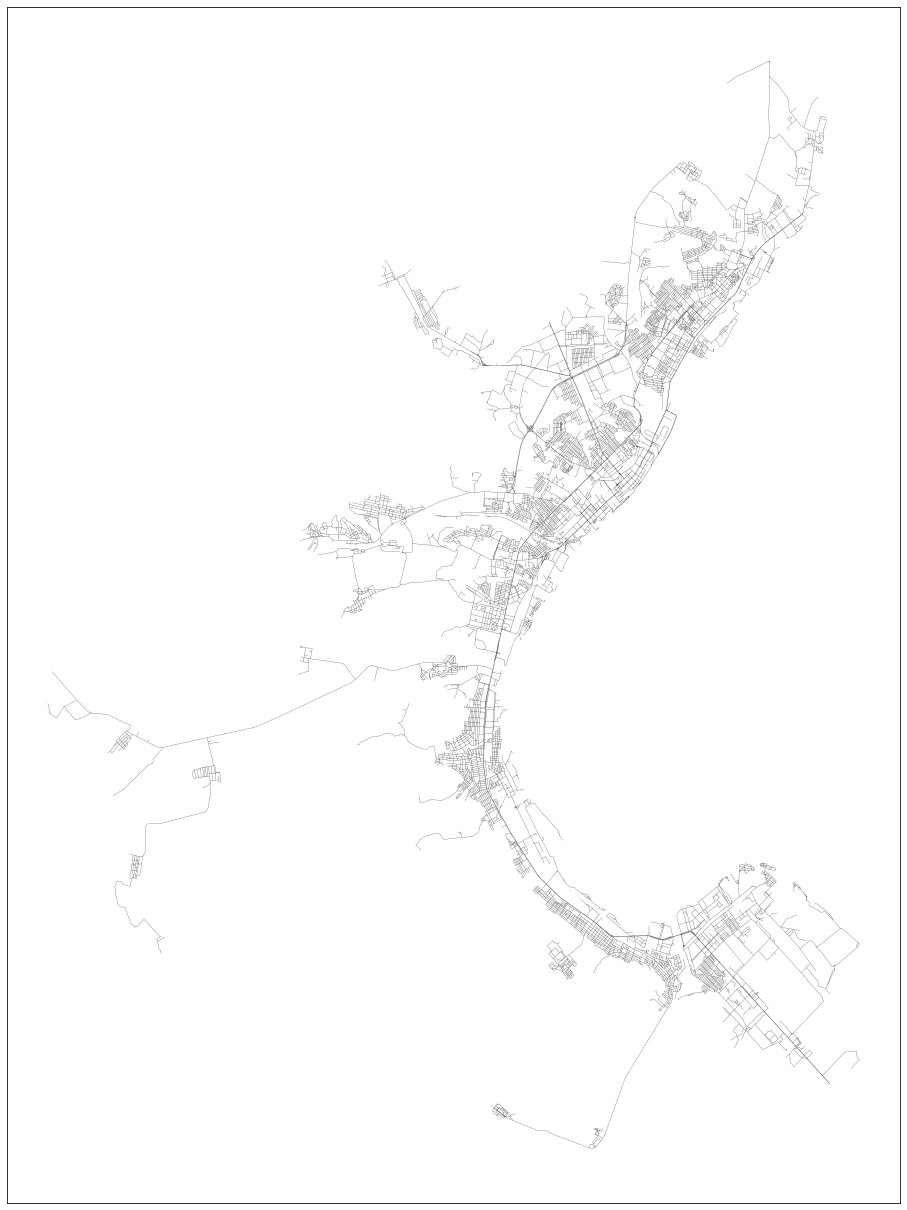

In [24]:
draw_graph(G,nodes)

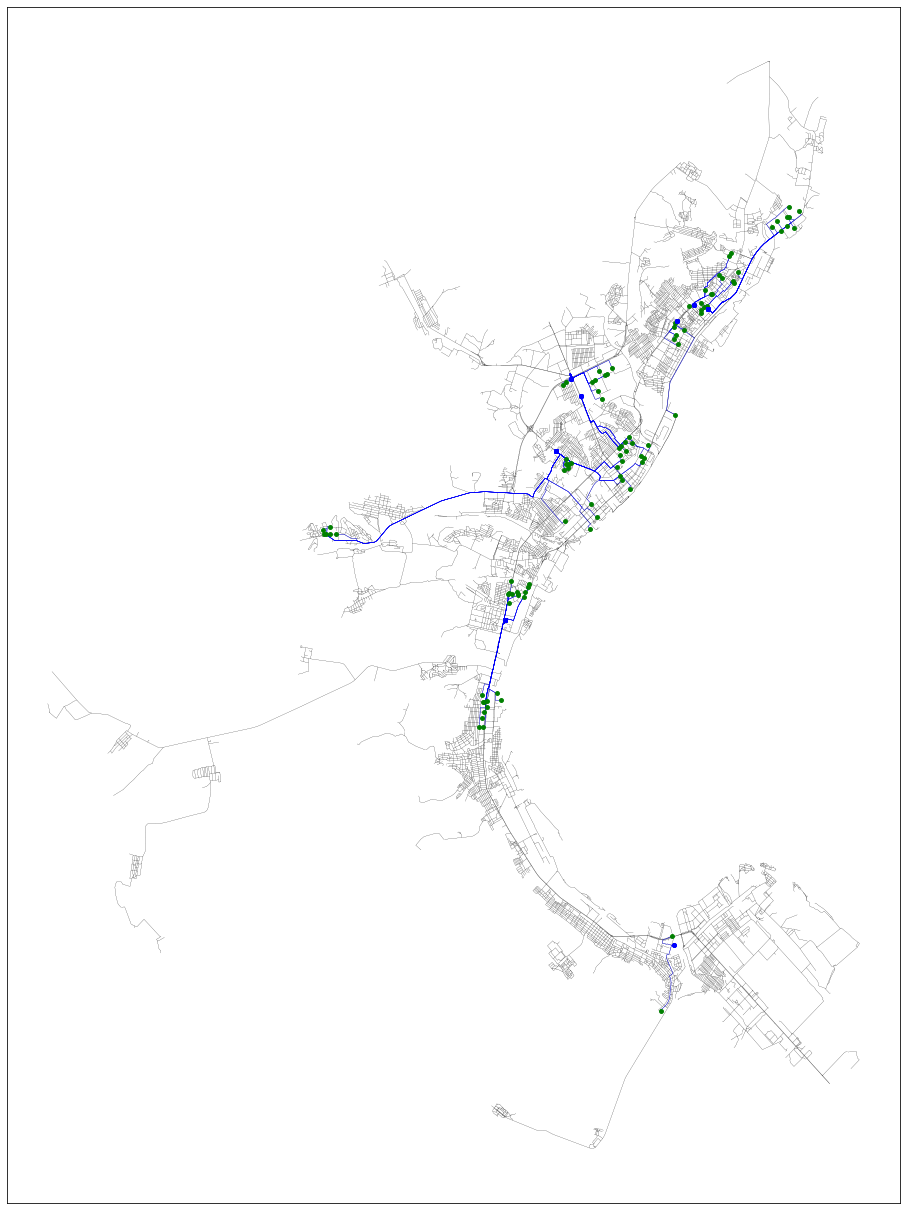

In [25]:
draw_ways_on_graph(G,nodes,min_oneways1)

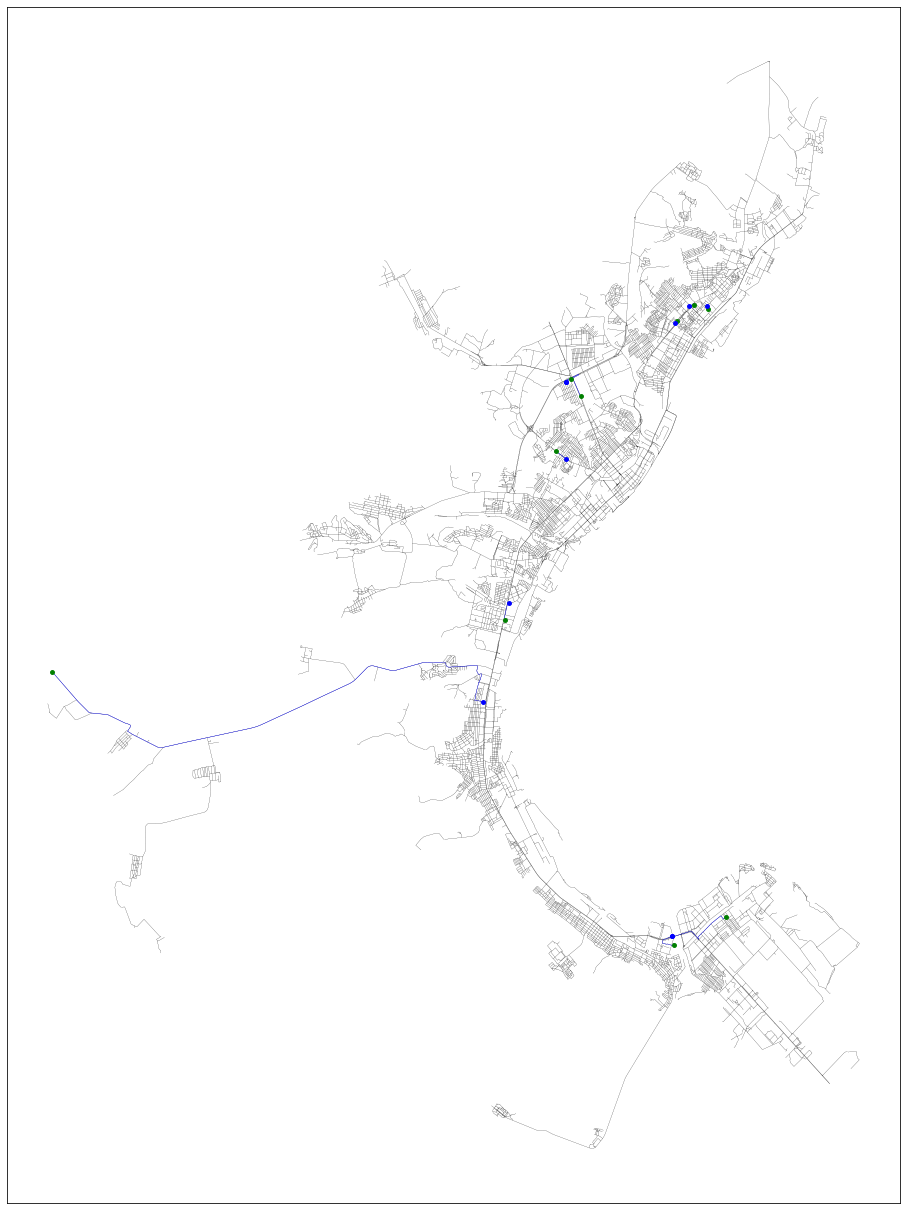

In [26]:
draw_ways_on_graph(G,nodes,min_oneways2)

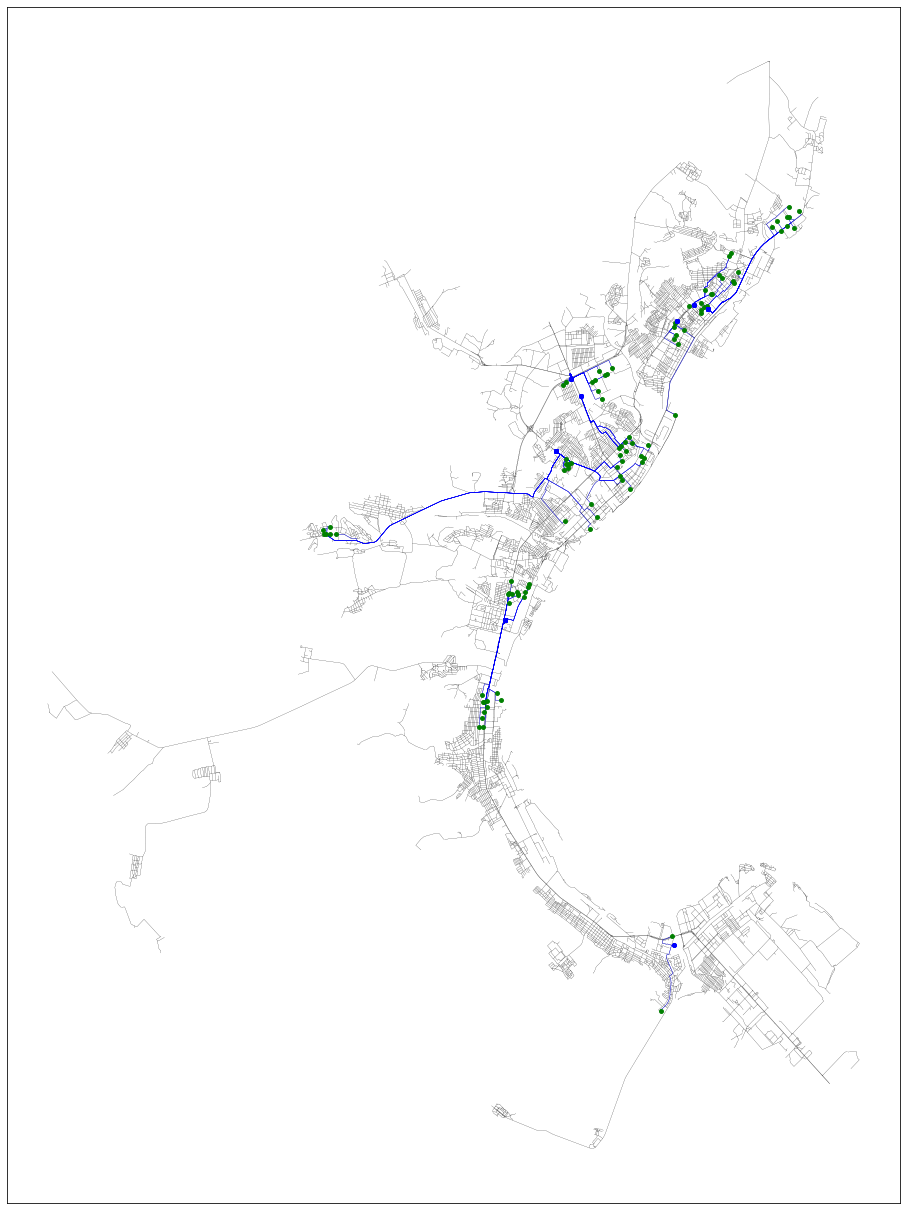

In [27]:
draw_ways_on_graph(G,nodes,min_ways_there_and_back)

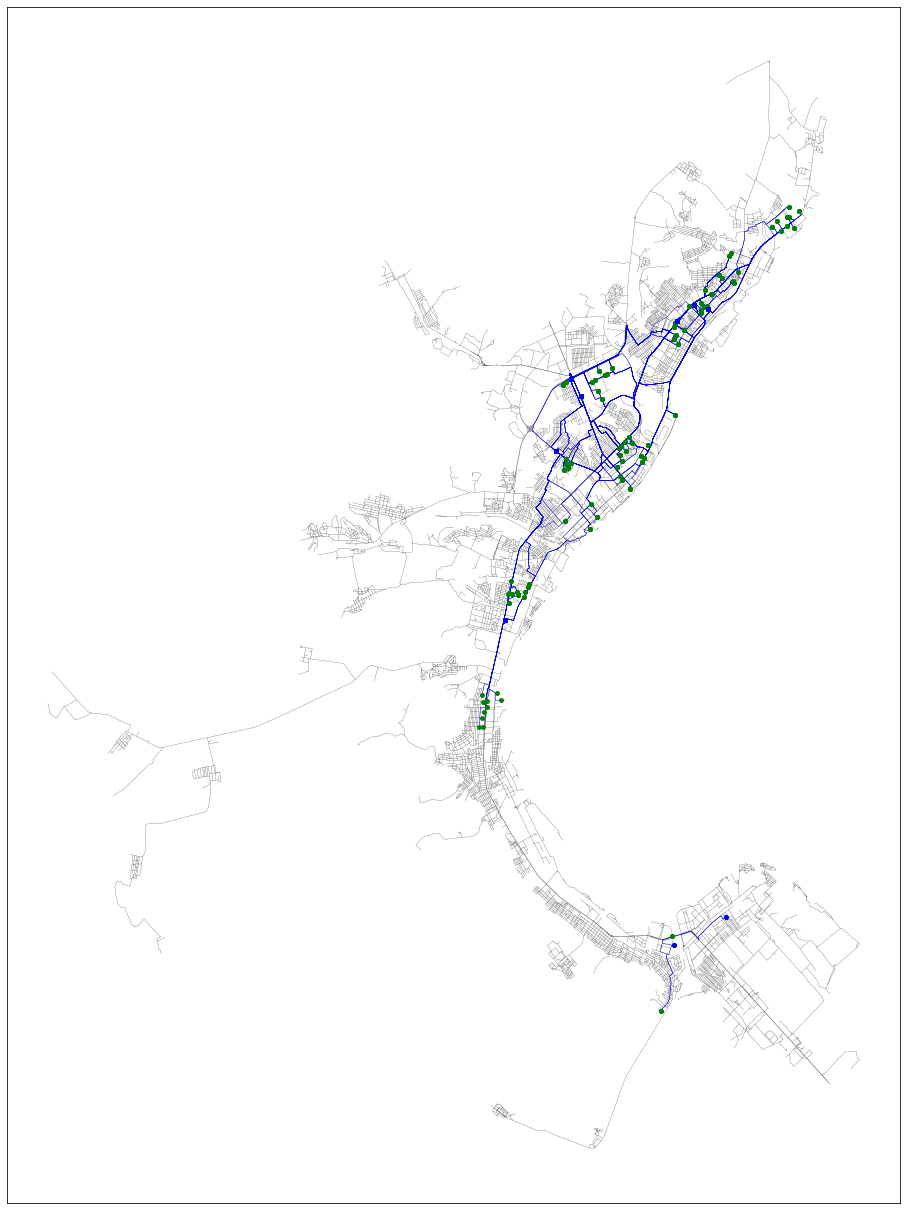

In [28]:
draw_ways_on_graph(G,nodes,near_ways1)

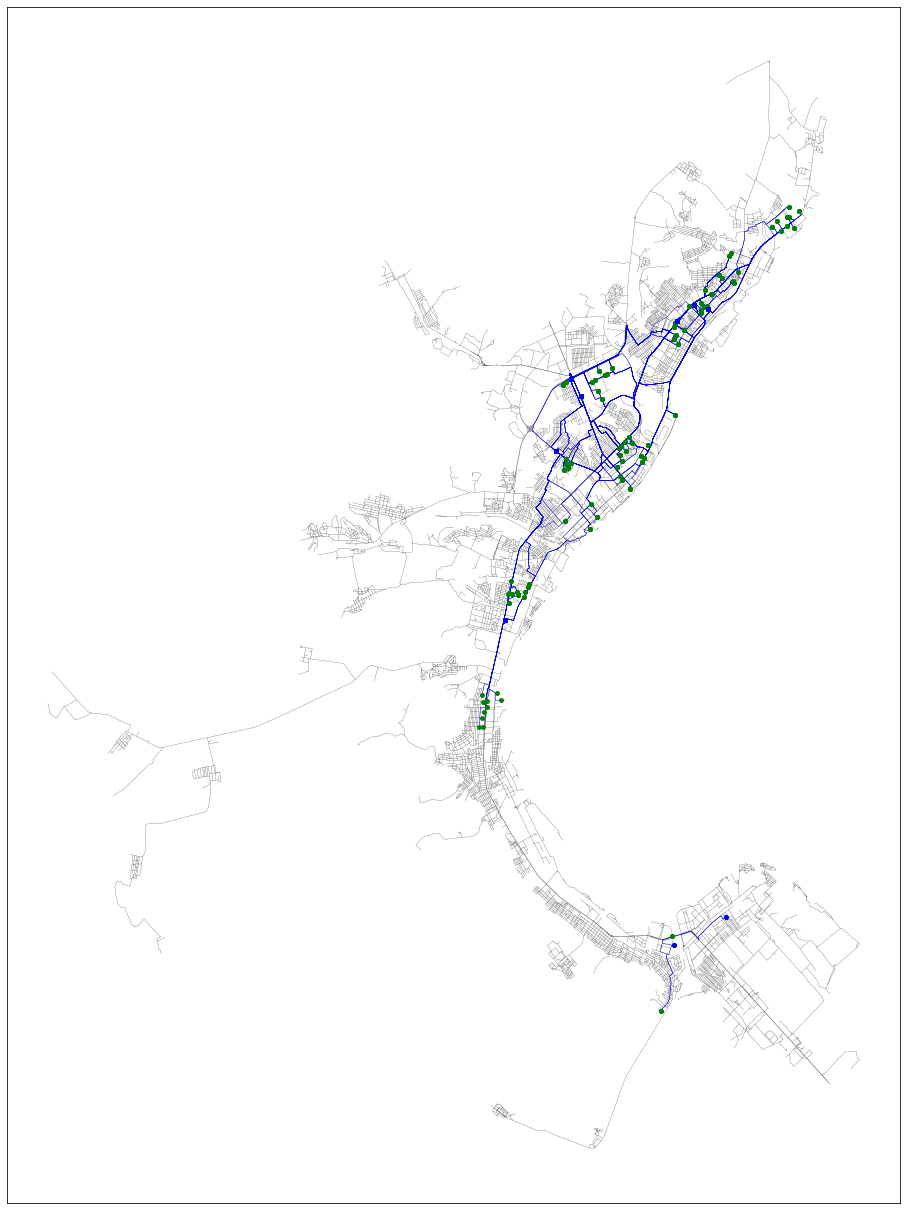

In [29]:
draw_ways_on_graph(G,nodes,near_ways2)

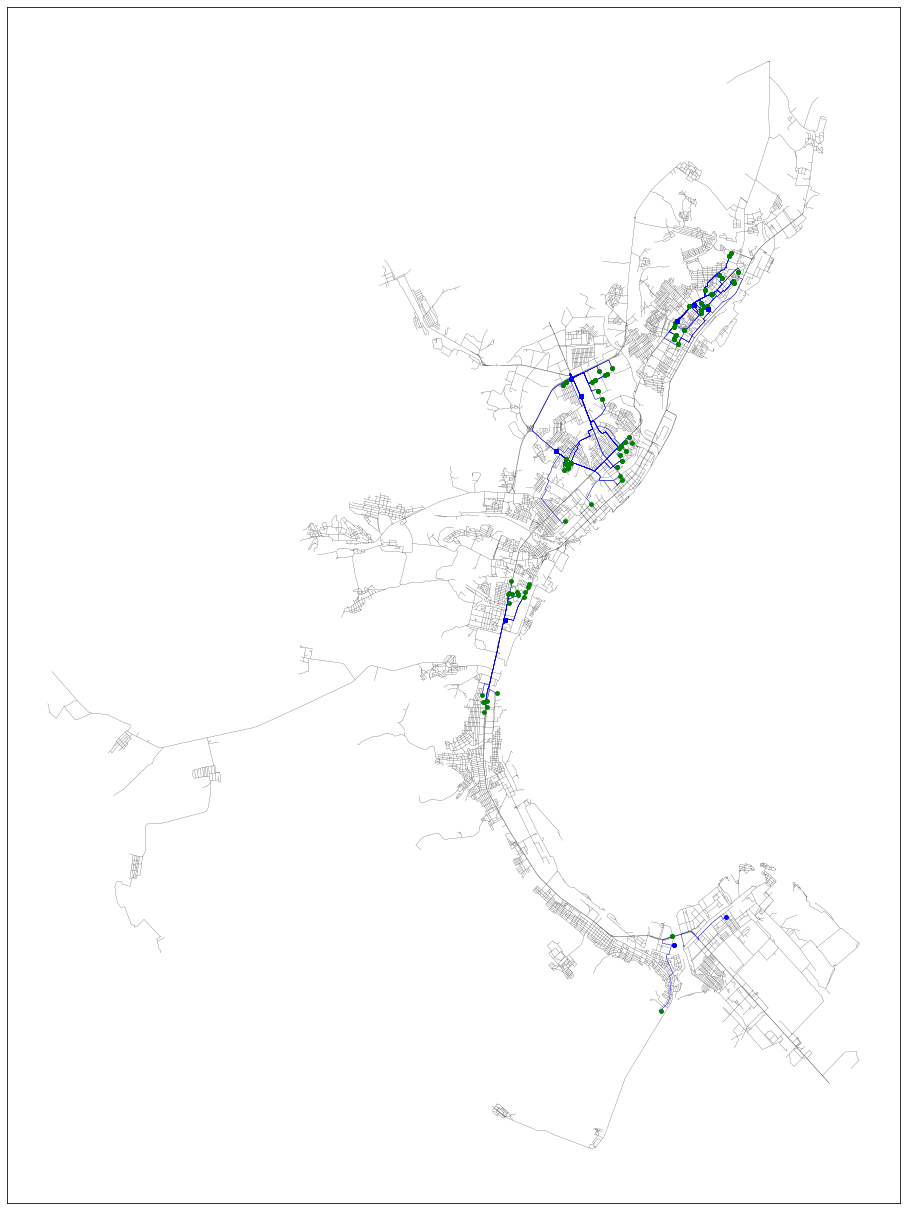

In [30]:
draw_ways_on_graph(G,nodes,near_ways_there_and_back)

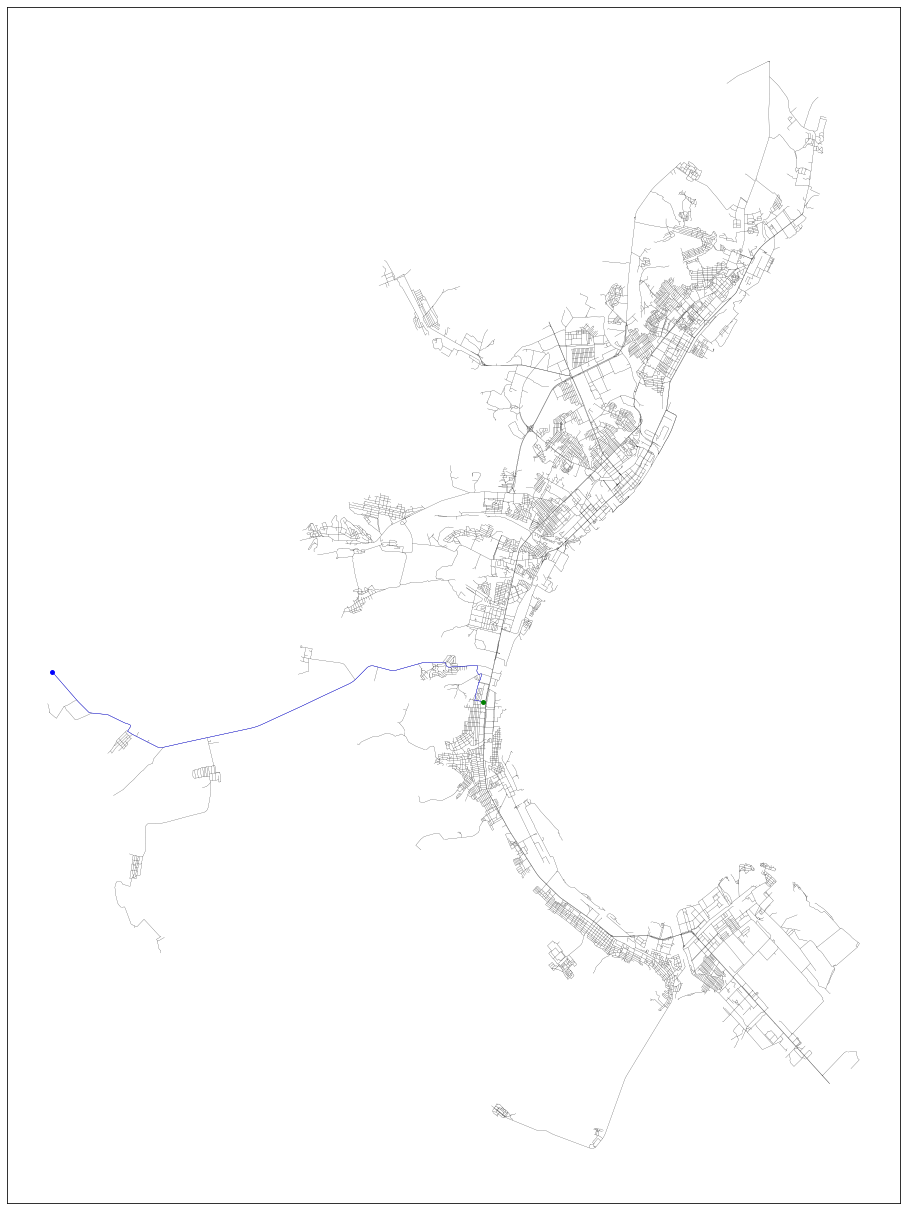

In [31]:
draw_ways_on_graph(G,nodes,minmax_way1)

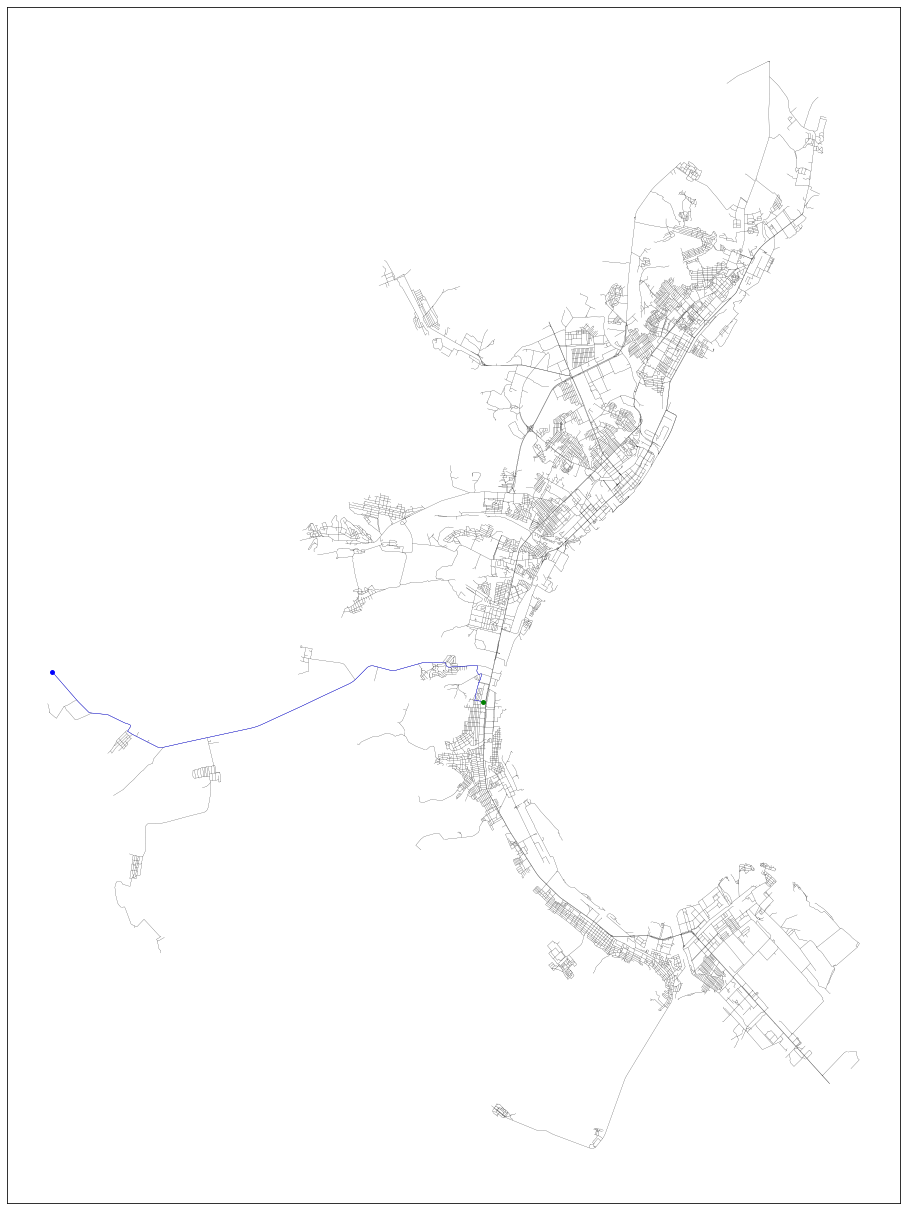

In [32]:
draw_ways_on_graph(G,nodes,minmax_way2)

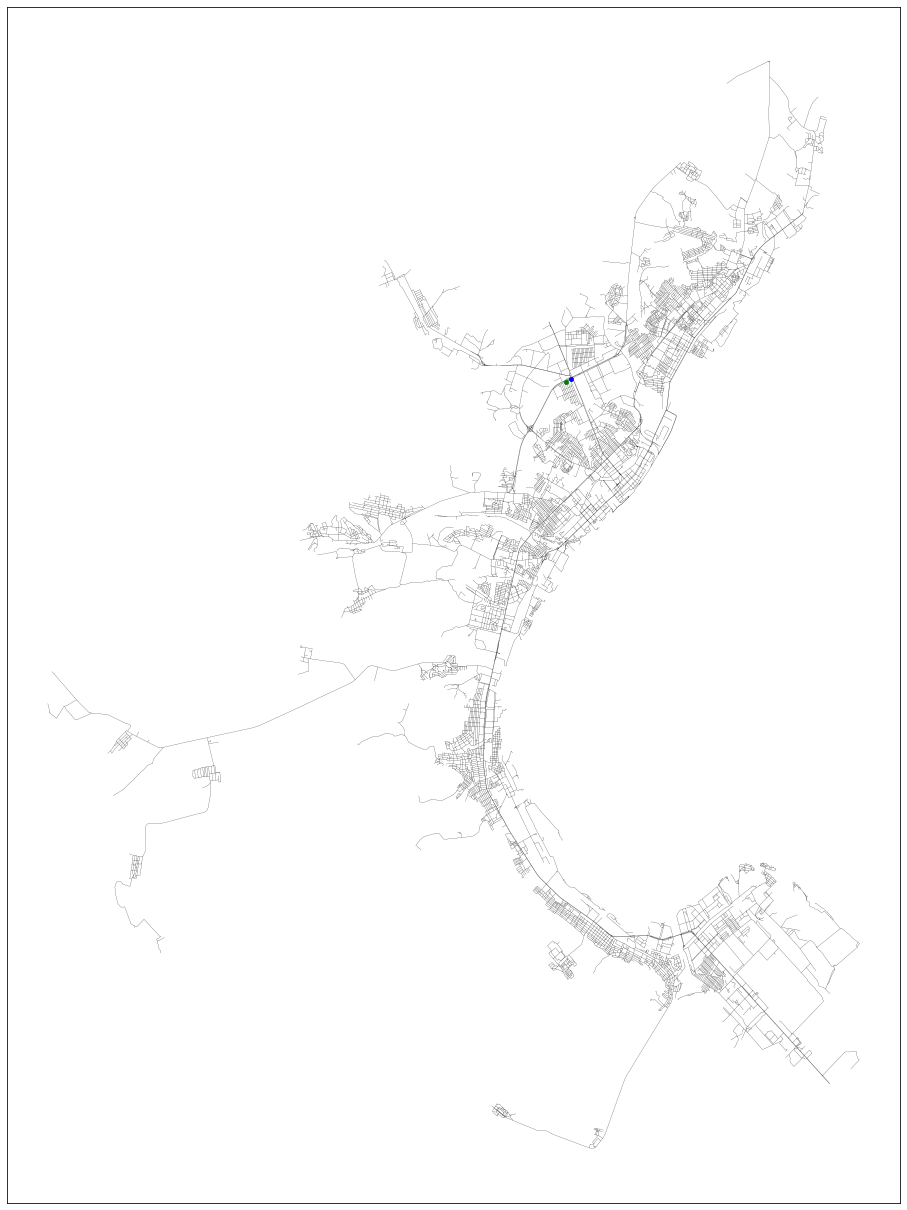

In [33]:
draw_ways_on_graph(G,nodes,minmax_way_there_and_back)

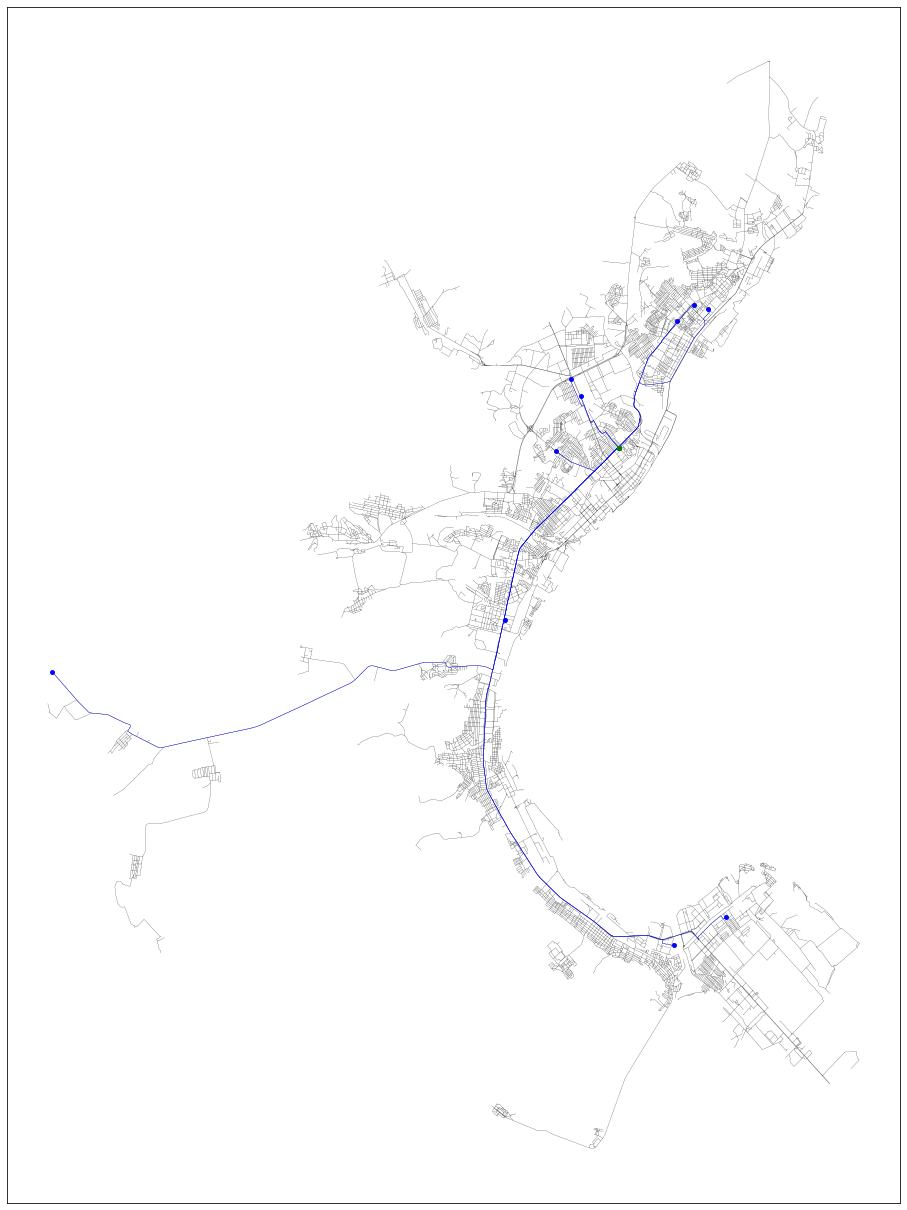

In [34]:
draw_ways_on_graph(G,nodes,min_distance_way)

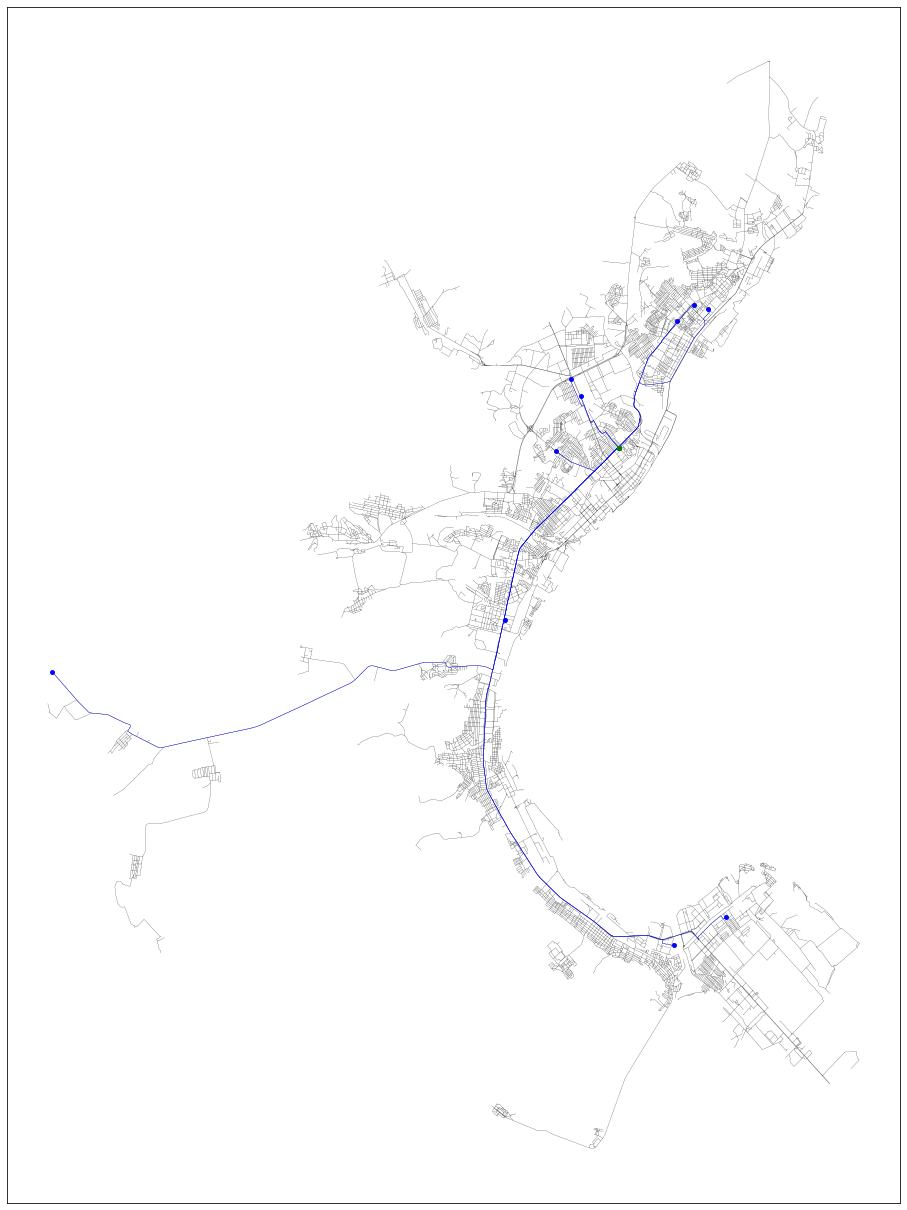

In [35]:
draw_ways_on_graph(G,nodes,min_weight_way)

In [36]:
# def draw_ways(_map,ways_orig):
#     if type(ways_orig) == dict:
#         ways = [way['way'] for way in ways_orig.values()]
#         if 'way_back' in ways_orig[list(ways_orig.keys())[0]].keys():
#             ways += [way['way_back'] for way in ways_orig.values()]
#     elif type(ways_orig) == list:
#         ways = [way[3] for way in ways_orig]
#         if len(ways_orig[0]) == 5:
#             ways += [way[4] for way in ways_orig]
#     ways = list(map(lambda x: (list(map(int,x))),ways))

#     ox.plot_graph_routes(_map, ways)
 

In [37]:
# import osmnx as ox
# _map = ox.core.graph_from_file('data/graph.osm',  simplify=False, retain_all=False)


In [38]:
#Создадим список смежности
nx.readwrite.adjlist.write_adjlist(G,'graph_tasks/adj_list.csv')

In [39]:
def write_adjlist(G,filename = 'graph_tasks/adj_list2.csv'):
#Список с весами
    with open(filename,'w',newline='') as csv_file:
        csv_file.write('from_id to_id,edge_weight\n')
        for _from in list(G.nodes):
            s = str(_from)
            for _to in G.successors(_from):
                s = s + ' ' + str(_to) + ',' + str(G[_from][_to]['weight'])
            csv_file.write(s + '\n')


In [40]:
write_adjlist(G)

In [41]:
#Создадим матрицу смежности
#nx.linalg.graphmatrix.adjacency_matrix(G)
adj_matrix = nx.to_pandas_adjacency(G)

In [42]:
adj_matrix

,1688220386,5244338893,5244338894,5244338895,5244338896,5244338897,5244338898,1155399734,5244338899,1688220397,...,1611661282,419065672,3240361956,565575660,565575662,565575663,565575671,565575673,565575675,565575678
1688220386,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5244338893,0.0,0.000000,0.004485,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5244338894,0.0,0.004485,0.000000,0.005448,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5244338895,0.0,0.000000,0.005448,0.000000,0.004485,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5244338896,0.0,0.000000,0.000000,0.004485,0.000000,0.004696,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565575663,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.058638,0.0,0.0,0.0,0.0,0.0,0.0,0.0
565575671,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
565575673,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
565575675,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
matrix = adj_matrix.values
print(matrix)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.00448469 ... 0.         0.         0.        ]
 [0.         0.00448469 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [ ]:
adj_matrix.to_csv('graph_tasks/adj_matrix.csv')